## 固定比例法

已知五年(2018/7/10 - 2023/7/10)的螺纹钢主连收盘价数据，来观察用固定比例法交易五年后的总资金变化。

if 现有资金 < 初始资金: 
$$ 合约数 = 1 $$

if 现有资金 > 初始资金:
$$ 合约数 = int(\frac{1 + \sqrt{(1 + 8 * \frac{总资金 - 初始资金}{\Delta})}}{2}) $$

### 螺纹钢交易规则

一手 = 10吨

一手螺纹钢保证金 = 10吨 * 开仓价格（此处暂用当天收盘价来代替） * (13+3)%

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import math

In [2]:
def read_data(path):
    '''
    :param path: 存有5 years螺纹钢主连的收盘价等数据
    :return:
    日期      收盘价(元)
    ...         ...
    ...         ...
    '''
    source_df = pd.read_excel(path)
    df = source_df[["时间", "收盘价(元)"]]
    return df

In [3]:
def backtest_df(df, C, delta, guarantee):
    '''
    :param df:
        日期      收盘价(元)
        ...         ...
        ...         ...
    :param C: 初始资金
    :param num: 初始买入合约数
    :param delta: 当平均每份合约增加\delta的时候，再多买进一份合约
    :param guarantee: 保证金比例
    :return:
        日期      收盘价(元)      contract_number     Total_asset     Used_asset
        ...         ...         ...                 ...             ...
        ...         ...         ...                 ...             ...
    '''
    total_asset = C * np.ones(len(df))             # 总资金 at day1
    con_num = np.ones(len(df))               # 合约数 at day1
    used_asset = 1 * 10 * (
        df["收盘价(元)"][0] * guarantee) / C * np.zeros(len(df))           # 占用资金 at day1
    lever_ratio = 1 * 10 * (
        df["收盘价(元)"][0]) / C * np.zeros(len(df))
    
    for index in range(1,len(df)):
        # Total asset
        total = con_num[index - 1] * 10 * (df["收盘价(元)"][index] - df["收盘价(元)"][index - 1]) # 10吨/手
        total_asset[index] = total_asset[index - 1] + total
        
        if (total_asset[index] - C < 0):
            con_num[index] = 1
        else:
            con_num[index] = int(0.5 * (1 + math.sqrt(1 + 8 * (total_asset[index] - C) / delta)))
        # Used asset
        used_asset[index] = con_num[index] * 10 * df["收盘价(元)"][index] * guarantee / total_asset[index]
        
        lever_ratio[index] = con_num[index] * 10 * df["收盘价(元)"][index] / total_asset[index]

    df["contract_number"] = con_num
    df["Total_asset"] = total_asset
    df["Used_asset"] = used_asset
    df["Lever_ratio"] = lever_ratio

    return df

In [18]:
def total_asset_plot(x, y, C):
    '''
    :param x: 图像的x值，一般是日期
    :param y: 图像y值，一般是total asset value
    :return: None，因为要画图
    '''
    fig, ax = plt.subplots()
    ax.plot(x, y)
    # 设置其他参数
    ax.set_xlabel("Date")
    ax.set_ylabel("Asset(yuan)")
    ax.set_xticks(x[::90])
    ax.set_title("Total asset when using Fixed Fractional", fontsize=13)

    # 总资产最高点和最低点
    x = x.to_list()
    y = y.to_list()
    ind_max = y.index(max(y))
    ind_min = y.index(min(y))
    max_benefit = (max(y) - C) * 100/ C
    min_benefit = (min(y) - C) * 100/ C
    ax.axhline(C, color="red", linestyle="--")
    
    ax.text(x[ind_min], y[ind_min], f"Min:{min(y)}, Benefit:{min_benefit}%")
    ax.text(x[ind_max], y[ind_max], f"Max:{max(y)}, Benefit:{max_benefit}%")
    ax.text(x[0], y[0], f"Orginal Asset:{C}")
    
    ax.grid(linestyle = "--")

    # 自动调整x坐标轴
    plt.gcf().autofmt_xdate()
    # Show the figure
    plt.show()

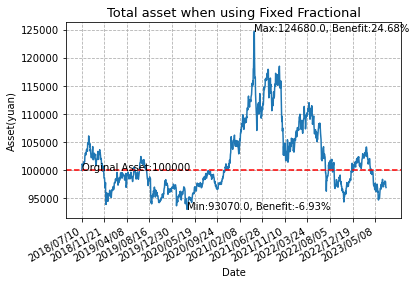

              时间  收盘价(元)  contract_number  Total_asset  Used_asset  \
0     2018/07/10    3862              1.0     100000.0    0.000000   
1     2018/07/11    3879              1.0     100170.0    0.061959   
2     2018/07/12    3976              1.0     101140.0    0.062899   
3     2018/07/13    3959              1.0     100970.0    0.062735   
4     2018/07/16    3958              1.0     100960.0    0.062726   
...          ...     ...              ...          ...         ...   
1209  2023/07/04    3768              1.0      98090.0    0.061462   
1210  2023/07/05    3751              1.0      97920.0    0.061291   
1211  2023/07/06    3758              1.0      97990.0    0.061361   
1212  2023/07/07    3671              1.0      97120.0    0.060478   
1213  2023/07/10    3654              1.0      96950.0    0.060303   

      Lever_ratio  
0        0.000000  
1        0.387242  
2        0.393118  
3        0.392097  
4        0.392036  
...           ...  
1209     0.384137  

In [26]:
if __name__ == '__main__':
    path = "/Users/yuwensun/Documents/实习/申港资管投资部23Summer/资管方法及其应用/螺纹钢主力连续（近五年）.xls"
    df = read_data(path) # DataFrame contains 日期and收盘价

    # 交易参数设置
    C = 100000                             # 初始资金                                 
    delta = 20000                            # 当平均每份合约增加\delta的时候，再多买进一份合约
    guarantee = 0.16                         # 保证金比例                                
    
    final_df = backtest_df(df, C, delta, guarantee)

    total_asset_plot(final_df["时间"], final_df["Total_asset"], C)
    
    # print(sum(final_df["contract_number"] == 80.0))
    print(df)